# Application example: Using DIG on German Credit dataset

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx

from sklearn.metrics import f1_score, plot_precision_recall_curve, plot_roc_curve, plot_confusion_matrix


import sys; sys.path.insert(0, '..') # add parent folder path where discrepancies folder is

from discrepancies import datasets, pool, discrepancies_intervals, DIG_main, analysis_global

RANDOM_STATE = 42

import matplotlib.pyplot as plt
%matplotlib inline

## Data and models preparation

We use the German Credit dataset (https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data)). 
The preprocessing steps applied to the data can be found in the ../discrepancies/datasets.py file. It includes rescaling and centering of the data, one-hot encoding categorical features and splitting the data into train and test.

For this example, a pool of basic models are trained on the training data. It includes classifiers such as Random Forest, SVM, Logistic Regression, XGBoost and Gradient Boosting. DIG is completely model agnostic, meaning that any classifier (no matter how many) can be added to the pool.

[15:32:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracies (F1):  {'SVMrbf': 0.8454935622317598, 'RF200': 0.8372093023255814, 'XGB': 0.8584269662921347, 'LR': 0.8487584650112867, 'GB': 0.841870824053452}
Discrepancies on train: 0.21142857142857144
Discrepancies on test: 0.24666666666666667


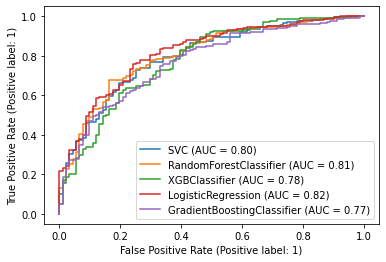

In [7]:
# Get data and fit a pool of classifiers on it 
X_train, X_test, y_train, y_test, scaler, feature_names, target_names, cat_names = datasets.get_dataset(dataset='german', test_size=0.3)
cont_names = list(set(feature_names) - set(cat_names))

pool1 = pool.BasicPool(models=["SVMrbf", "RF200", "LR", "XGB", "GB"])
pool1 = pool1.fit(X_train.values, y_train)

preds = pool1.predict(X_test)

print("Accuracies (F1): ", {c: f1_score(y_test, preds[c]) for c in preds.columns})
print("Discrepancies on train:", pool1.predict_discrepancies(X_train).mean())
print("Discrepancies on test:", pool1.predict_discrepancies(X_test).mean())

classifiers = [v for k, v in pool1.models.items()]#[pool1.models["SVMrbf"], pool1.models["RF200"]]
ax = plt.gca()
for i in classifiers:
    plot_roc_curve(i, X_test, y_test, ax=ax)

# for i in classifiers:
#     plot_confusion_matrix(i, X_test, y_test, normalize='all')
#     plt.show()


## Fitting DIG

In this first step, DIG learns the discrepancies between the models from the pool. The output is an object (called 'pool2graph') which can be used to generate different types of explanations to understand where these discrepancies lie in the feature space. 

It takes as inputs: 
- the training data X_train and y_train (N.B. currently, X_train should be a pandas dataset, with feature names --> however, this can be easily modified in the code if needed)
- the pool object
- the list of the categorical features names, if relevant (otherwise, leave the parameter empty)

DIG parameters:
- k_init: The number of neighbors considered to explore the feature space. Local exploration parameter: the higher the more accurate it is, but the longer it takes.
- max_epochs: Number of iterations performed to refine the graph. The higher, the more precise the approximation is along the segments defined with k_init (but the longer it takes).

In [10]:
%%time 
disc_graph = DIG_main.pool2graph(X_train, y_train, pool1, k_init=10, categorical_names=cat_names)

disc_graph.fit(max_epochs=5)
intervals = discrepancies_intervals.get_discrepancies_intervals(disc_graph.G)

print(len(intervals))

INFO:root:### EPOCH #1
INFO:root:### EPOCH #2
INFO:root:### EPOCH #3
INFO:root:### EPOCH #4
INFO:root:### EPOCH #5


CPU times: user 2min 3s, sys: 7.27 s, total: 2min 11s
Wall time: 1min 38s


## Extracting explanations from DIG

Preprocessing the graph

In [12]:
%% time
# extracting various information from the graph
gda = analysis_global.GlobalDiscrepancyAnalyzer(p2g, pool1, intervals, X_train, cat_names)

Intervals amplitude dataset (self.amplitude_dataset): shape (14695, 63)
Input data preprocessed (self.X): shape (700, 64)
Discrepancy nodes dataset (self.nodes_dataset): shape (84505, 63)
Nodes dataset (self.nodes_dataset): shape (113671, 64)


### Contributions of each features to global discrepancy

Different ranking / importance for continuous and categorical features for now

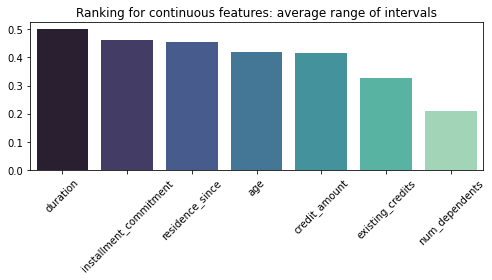

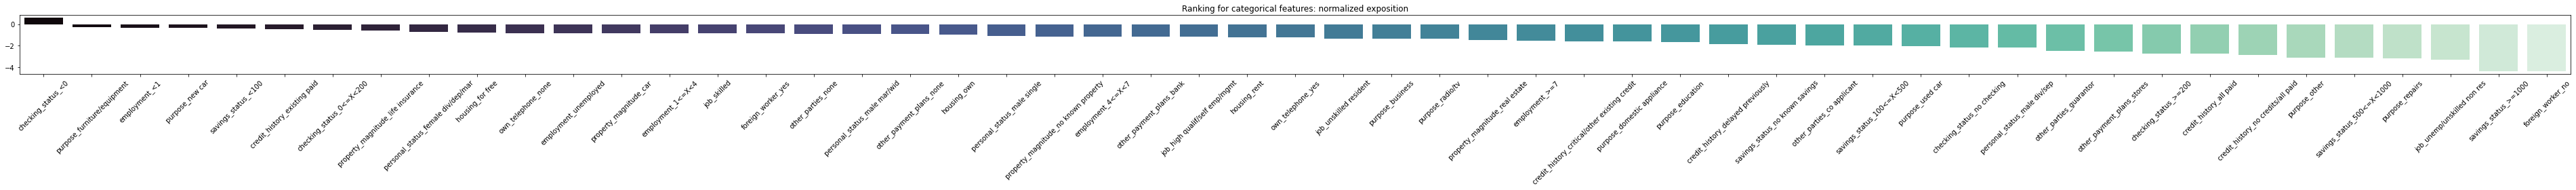

In [13]:
feat_imp = gda.get_global_discrepancy_importances(min_expo=10)
gda.plot_feature_importances(palettes=['mako', 'mako'])#, savefig='')

### Discrepancy segments

This function detects major discrepancy segments. Segments are defined by rules in the form of (FEATURE_i > THRESHOLD_i). Statistics are calculated over these segments: accuracy of models, size of the segment, purity of the segment...

The CART model used to detect these segments can be called with gda.segments_tree

Inputs:
- X_exposition: ground-truth data, e.g. X_train or X_test, used to justify the segments returned
- y_exposition: same

Parameters:
- min_expo: imposes segments to contain a minimum portion of exposition instances
- min_purity: filter on the purity (in terms of discrepancy) of the segments that are to be returned. Concretely, only the segments that contain a portion of min_purity of instances that have discrepancy will be returned.
- min_purity_expo: same but purity calculated on X_exposition instead of the nodes

In [16]:
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.7, min_purity_expo=0.0)

Discrepancy segments tree accuracy on nodes: 0.6397996532460027
... on exposition data 0.47956403269754766
====== SEGMENT 16 ======
=== Segment description:
decision node 0 : checking_status_no checking <= 0.5)
decision node 1 : duration > 0.742146223783493)
decision node 15 : credit_amount <= 1.354268729686737)
=== Segment characteristics
Segment exposition: 0.06857142857142857
Segment node population (proxy for size?): 0.1403240331902318
Percent of the discrepancy nodes contained here: 0.21896471895545883
Segment purity: 0.7366814131721603
Segment purity (X_expo): 0.4166666666666667
Accuracy of classifiers (F1 on X_expo) on segment: {'SVMrbf': 0.7368421052631577, 'RF200': 0.8888888888888888, 'XGB': 0.9090909090909091, 'LR': 0.6938775510204082, 'GB': 0.8333333333333333}
Number of discrepancy segments found: 1


### Local Interval of Discrepancy

For one instance (any instance, assigned with discrepancy or not), returns an explanation about where the closest area of discrepancy is. This information takes the form of a "discrepancy interval", specifying for instance that there is a disagreement among models for "blond persons between 25 and 30 years old".




In [ ]:
import matplotlib as mpl
idx = 67
instance = X_test.iloc[idx]

fi = interval_relevant[cont_names]#fi[cont_names]
#fi = borders[1]
x = instance[cont_names]

mpl.style.use('default')
plt.viridis()

fig, ax = plt.subplots(figsize=(8,5))
plt.bar(x=range(len(x)), height=normalize(fi.max())-normalize(fi.min()), bottom=normalize(fi.min())-normalize(x))

plt.hlines(0, -0.5, len(cont_names), color='r')

for i in range(len(x)):
    y1 = normalize(fi.max()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y1+0.03, str(fi.max().round(2).iloc[i]))

for i in range(len(x)):
    y2 = normalize(fi.min()).iloc[i] - normalize(x).iloc[i]
    ax.text(i-0.45, y2-0.04, str(fi.min().round(2).iloc[i]))

for i in range(len(x)):
    y2 = -0.5
    ax.text(i-0.45, y2-0.04, str(x.round(2).iloc[i]), c='r')

gar = ax.set_ylim((-0.55,1.2))
gar = ax.set(yticklabels=[])
gar = ax.tick_params(left=False)
gar = plt.xticks(np.arange(len(x)), list(x.index), rotation=90)

housing_rent
0    594
1    126
Name: duration, dtype: int64


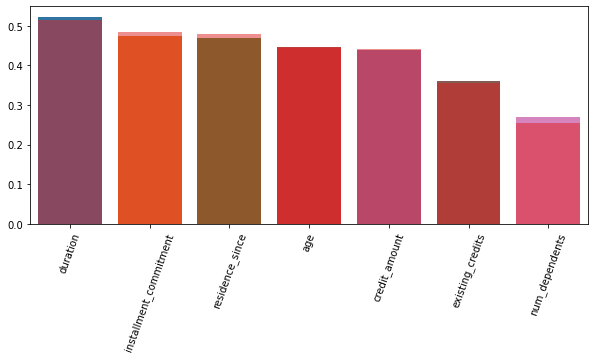

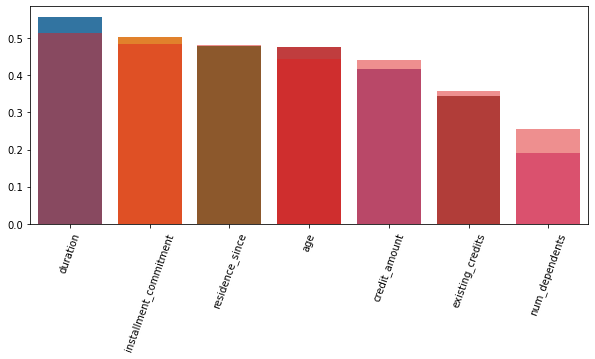

In [230]:
catfeat_name = "housing_rent"

temp = gda.amplitude_dataset.groupby(catfeat_name).mean()[cont_names]
print(X_train.groupby(catfeat_name).count().iloc[:,0])
for i in temp.index:
    tempi = temp.loc[i].sort_values(ascending=False)
    plt.figure(figsize=(10,4))
    plt.xticks(rotation=70, fontsize=10)
    sns.barplot(data=pd.DataFrame(tempi).T)
    sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, color="red", alpha=0.5)
    plt.show()
    

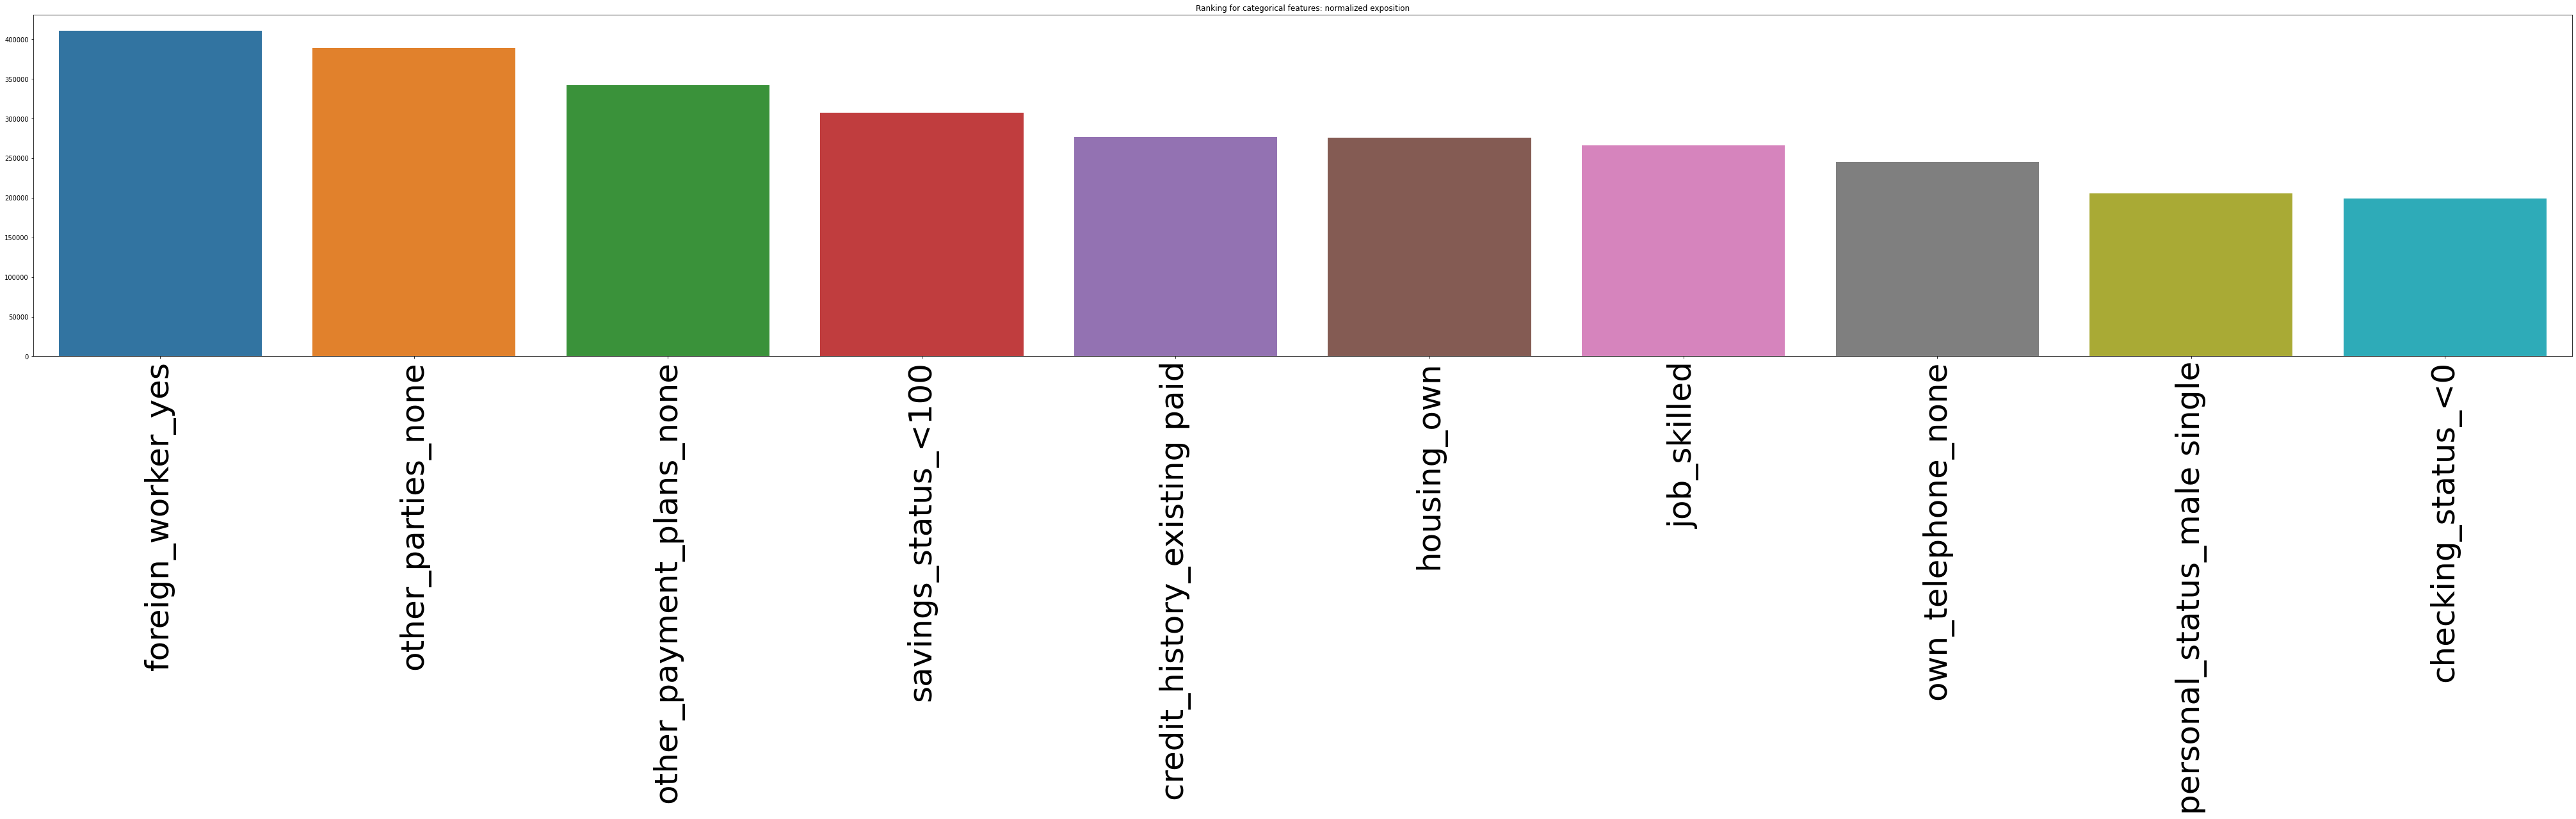

In [266]:
plt.figure(figsize=(len(cat_names),10))
plt.xticks(rotation=90)
sns.barplot(data=pd.DataFrame(gda.disc_nodes_dataset[cat_names].sum(axis=0).sort_values(ascending=False)[:10]).T)
plt.title("Ranking for categorical features: normalized exposition")
plt.tight_layout()
plt.xticks(size=50)
plt.show()
            

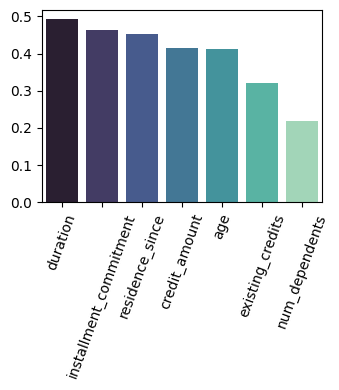

In [361]:
plt.figure(figsize=(len(feat_imp['continuous_features'])/2,4))
plt.xticks(rotation=70, fontsize=10)
sns.barplot(data=pd.DataFrame(feat_imp['continuous_features']).T, palette="mako")
#plt.title(" features")
plt.tight_layout()
#plt.savefig("./../../results/usecase_boston_featimp_cont.pdf")
plt.show()

### Important areas of discrepancy

In [14]:
%%time
gda.get_discrepancy_segments(X_exposition=X_train, y_exposition=y_train, min_expo=0.05, min_purity=0.7, min_purity_expo=0.0)



Discrepancy segments tree accuracy on nodes: 0.6397996532460027
... on exposition data 0.47956403269754766
====== SEGMENT 16 ======
=== Segment description:
decision node 0 : checking_status_no checking <= 0.5)
decision node 1 : duration > 0.742146223783493)
decision node 15 : credit_amount <= 1.354268729686737)
=== Segment characteristics
Segment exposition: 0.06857142857142857
Segment node population (proxy for size?): 0.1403240331902318
Percent of the discrepancy nodes contained here: 0.21896471895545883
Segment purity: 0.7366814131721603
Segment purity (X_expo): 0.4166666666666667
Accuracy of classifiers (F1 on X_expo) on segment: {'SVMrbf': 0.9189189189189189, 'RF200': 0.9714285714285714, 'XGB': 1.0, 'LR': 0.6315789473684211, 'GB': 0.9696969696969697}
Number of discrepancy segments found: 1
CPU times: user 1min 28s, sys: 8.31 s, total: 1min 36s
Wall time: 33 s


<AxesSubplot:>

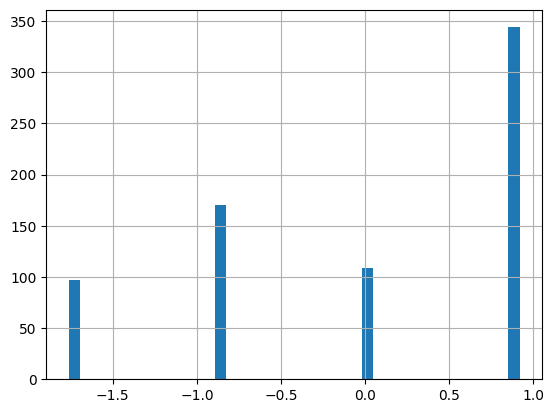

In [356]:
X_train["installment_commitment"].hist(bins=40)

In [347]:
list(enumerate(X_train.columns))

[(0, 'duration'),
 (1, 'credit_amount'),
 (2, 'installment_commitment'),
 (3, 'residence_since'),
 (4, 'age'),
 (5, 'existing_credits'),
 (6, 'num_dependents'),
 (7, 'credit_history_no credits/all paid'),
 (8, 'credit_history_all paid'),
 (9, 'credit_history_existing paid'),
 (10, 'credit_history_delayed previously'),
 (11, 'credit_history_critical/other existing credit'),
 (12, 'checking_status_<0'),
 (13, 'checking_status_0<=X<200'),
 (14, 'checking_status_>=200'),
 (15, 'checking_status_no checking'),
 (16, 'purpose_new car'),
 (17, 'purpose_used car'),
 (18, 'purpose_furniture/equipment'),
 (19, 'purpose_radio/tv'),
 (20, 'purpose_domestic appliance'),
 (21, 'purpose_repairs'),
 (22, 'purpose_education'),
 (23, 'purpose_vacation'),
 (24, 'purpose_retraining'),
 (25, 'purpose_business'),
 (26, 'purpose_other'),
 (27, 'savings_status_<100'),
 (28, 'savings_status_100<=X<500'),
 (29, 'savings_status_500<=X<1000'),
 (30, 'savings_status_>=1000'),
 (31, 'savings_status_no known savings'

In [355]:
X_train[X_train["credit_amount"]>1.51].shape , X_train.shape

((63, 63), (720, 63))

<AxesSubplot:ylabel='Density'>

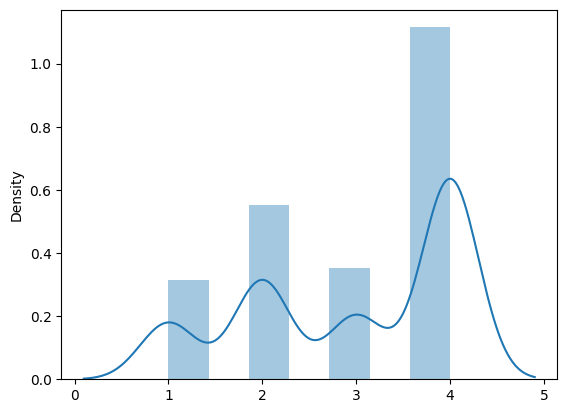

In [358]:
sns.distplot(scaler.inverse_transform(X_train)[:, 2])
#sns.distplot(scaler.inverse_transform(X_train[X_train["checking_status_no checking"] > 0.0])[:, 1])

In [341]:
data = X_train.mean()
data["duration"] = -0.67
data["credit_amount"] = -0.67#0.2062881737947464
data["installment_commitment"] = 0.43#0.2062881737947464
print(data)
print(X_train.columns)
scaler.inverse_transform(data.values.T)

duration                        -6.700000e-01
credit_amount                   -6.700000e-01
installment_commitment           4.300000e-01
residence_since                 -8.881784e-17
age                             -3.145632e-16
                                     ...     
job_high qualif/self emp/mgmt    1.652778e-01
own_telephone_none               5.722222e-01
own_telephone_yes                4.277778e-01
foreign_worker_yes               9.611111e-01
foreign_worker_no                3.888889e-02
Length: 63, dtype: float64
Index(['duration', 'credit_amount', 'installment_commitment',
       'residence_since', 'age', 'existing_credits', 'num_dependents',
       'credit_history_no credits/all paid', 'credit_history_all paid',
       'credit_history_existing paid', 'credit_history_delayed previously',
       'credit_history_critical/other existing credit', 'checking_status_<0',
       'checking_status_0<=X<200', 'checking_status_>=200',
       'checking_status_no checking', 'purpose_n

array([1.33240655e+01, 1.42125580e+03, 3.45336247e+00, 2.83888889e+00,
       3.54597222e+01, 1.41944444e+00, 1.14027778e+00, 5.54181605e-02,
       5.90651078e-02, 7.70734184e-01, 1.24043077e-01, 4.30856532e-01,
       3.84591104e-01, 4.04397933e-01, 7.76288412e-02, 5.82848105e-01,
       3.36385433e-01, 1.37989393e-01, 2.37248765e-01, 4.15416730e-01,
       1.55143036e-02, 2.89031237e-02, 4.99927631e-02, 0.00000000e+00,
       1.06761749e-02, 1.24043077e-01, 1.55143036e-02, 8.95836341e-01,
       1.30000000e-01, 8.32962551e-02, 6.08972474e-02, 2.52138381e-01,
       8.32962551e-02, 2.33010512e-01, 4.92675385e-01, 2.45746768e-01,
       3.60444308e-01, 4.81967903e-02, 4.63972461e-01, 8.23621545e-01,
       1.20089150e-01, 0.00000000e+00, 1.17000000e+00, 4.99927631e-02,
       7.20050733e-02, 4.02195336e-01, 3.29842097e-01, 4.92675385e-01,
       2.11934096e-01, 1.82784498e-01, 5.17950671e-02, 1.13561620e+00,
       2.41494243e-01, 1.03497513e+00, 1.48047819e-01, 2.54979010e-02,
      

In [359]:
instance

duration                        -0.274731
credit_amount                   -0.341956
installment_commitment           0.918536
residence_since                 -1.669695
age                             -0.751828
                                   ...   
job_high qualif/self emp/mgmt   -0.444976
own_telephone_none               0.864623
own_telephone_yes               -0.864623
foreign_worker_yes               0.201153
foreign_worker_no               -0.201153
Name: 866, Length: 63, dtype: float64

In [343]:
Xtest2 = X_test.copy()
Xtest2[cat_names] = (Xtest2[cat_names] > 0).astype('int')

#preds_segment = pool1.predict(X_test.iloc[np.where(gda.segments_tree.apply(Xtest2) == 24)[0],:])
#preds_segment["y"] = y_test.values[np.where(gda.segments_tree.apply(Xtest2) == 24)[0]]


LEAF = 25

preds_segment = pool1.predict(X_test.iloc[np.where(gda.segments_tree.apply(Xtest2) != LEAF)[0],:])
ysegment = y_test.values[np.where(gda.segments_tree.apply(Xtest2) != LEAF)[0]]
print(ysegment.mean())
print("Accuracies (F1): ", {c: f1_score(ysegment, preds_segment[c]) for c in preds_segment.columns})



0.7090909090909091
Accuracies (F1):  {'SVMrbf': 0.8564814814814815, 'RF200': 0.8498845265588914, 'XGB': 0.8515815085158152, 'LR': 0.8390243902439025, 'GB': 0.8349514563106796}


CPU times: user 6min 16s, sys: 12.2 s, total: 6min 28s
Wall time: 36.7 s


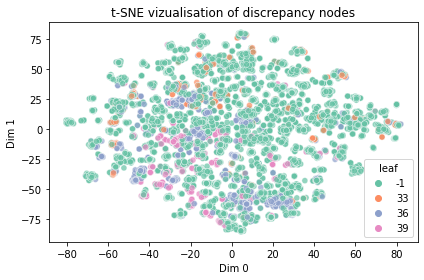

In [235]:
%%time

LEAVES_SEGMENTS = [33, 36, 39]

data = gda.disc_nodes_dataset.sample(n=10000)
leaves_data = gda.segments_tree.apply(data)
leaves_data_rearr = np.array([ld if ld in LEAVES_SEGMENTS else -1 for ld in leaves_data])

colors = list(sns.color_palette("Set2", n_colors=len(set(leaves_data))))

from sklearn.manifold import TSNE
tsne = TSNE(perplexity=50, n_jobs=-1).fit_transform(data)
tsne = pd.DataFrame(tsne, columns=["Dim 0", "Dim 1"])
tsne['leaf'] = leaves_data_rearr
#tsne["cluster"] = clusters
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.7)#, c=[colors[i] for i in leaves_data_rearr.values])
plt.title("t-SNE vizualisation of discrepancy nodes")
#plt.legend()
plt.tight_layout()
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

In [311]:
preds = pool1.predict(X_test)
preds["sum"] = preds.sum(axis=1)
preds[preds['sum'] == 3]

,SVMrbf,RF200,XGB,LR,GB,sum
64,1,1,0,1,0,3
214,1,0,1,1,0,3


## EN VRAI ICI au lieu du plus proche, on pourrait vouloir le plus proche parmi ceux avec les memes categorielles. ET si ca existe pas... Le plus proche dans les categorielles.

44

In [274]:
idx = 219

instance = X_test.iloc[idx, :]
instance[cat_names] = (instance[cat_names] > 0.0).astype("int")
from sklearn.metrics import pairwise_distances_argmin_min
#idx_closest = pairwise_distances_argmin(instance.values.reshape(1, -1), gda.disc_nodes_dataset)
#idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index
print((instance[cat_names] == gda.disc_nodes_dataset[cat_names].iloc[idx_closest, :]).sum().sum())
##on tente ici de faire filtre categorielles
idx_closest, min_ = pairwise_distances_argmin_min(instance[cat_names].values.reshape(1, -1), gda.disc_nodes_dataset[cat_names])
print(idx_closest, min_)
idx_closest = gda.disc_nodes_dataset.iloc[idx_closest].index

for ci in intervals:
    if idx_closest in list(ci.border_features.index):
        interval_relevant = ci.border_features
        break

52
[265] [1.41421356]


0
num_dependents
0.0
1
age
0.0
2
credit_amount
0.36168962237905317
3
installment_commitment
-0.8937103035896274
4
duration
1.2679892831251012
5
residence_since
-2.723974326831098
6
existing_credits
0.0


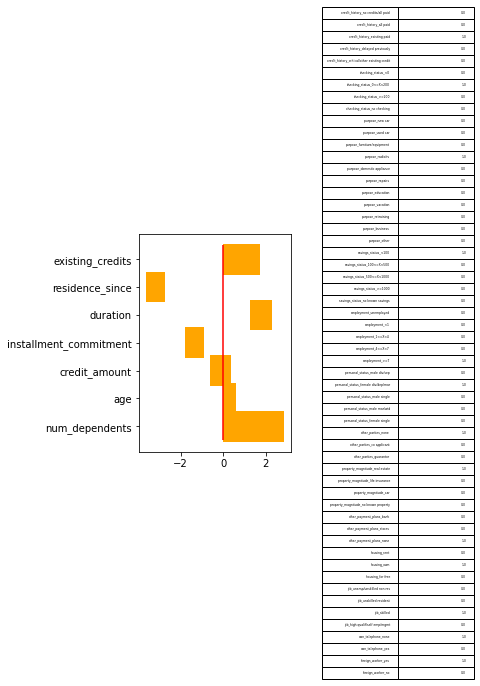

In [263]:
interval_to_plot = pd.DataFrame(scaler.inverse_transform(interval_relevant))
interval_to_plot.columns = X_train.columns
amplitude = pd.DataFrame(interval_to_plot.iloc[0, :] - interval_to_plot.iloc[1, :])
amplitude_normalized = interval_relevant.iloc[0, :] - interval_relevant.iloc[1, :]

interval_relevant2 = interval_relevant - instance

instance_orig_space = pd.DataFrame(scaler.inverse_transform(instance).reshape(1, -1))
instance_orig_space.columns = X_train.columns




fig, (ax1, ax2) = plt.subplots(1,2)
for i in range(len(cont_names)):
    print(i)
    print(cont_names[i])
    print(float(interval_relevant2.min()[cont_names[i]]))
    ax1.barh(y=i,left=float(interval_relevant2.min()[cont_names[i]]), height=1.1, width=float(amplitude_normalized[cont_names[i]]), color="orange")
    ax1.text(x=-3, y=i, s=)
ax1.set_yticks(ticks=range(len(cont_names)))   
contlabels = cont_names
ax1.set_yticklabels(labels=contlabels)
ax1.vlines(x=0, ymin=-0.5, ymax = i+0.5, color='red')

ax2.table(np.array(list(zip(cat_names, instance[cat_names]))).reshape(-1, 2), loc="center", fontsize=100)
ax2.axis("off")
plt.show()



In [266]:
def get_discrepancy_intervals_from_x(G, x, k=10):

    # Get all discrepancy intervals from the graph
    intervals = discrepancies_intervals.get_discrepancies_intervals(G)

    # Compute distances between x and every discrepancy interval
    dists = []
    for di in intervals:
        dists.append( di.get_min_dist_to_point(x) )

    # Retrieve borders of the k closest intervals - and the points from the train at the origin of the intervals
    borders, train = {}, {}
    i = 0
    for di in np.array(intervals)[np.argsort(dists)][:k]:
        df = di.border_features
        df = pd.DataFrame(df)
        borders[i] = df 

        df = [p2g.G.nodes(data=True)[di.X_train_nodes[i]]['features'] for i in [0,1]]
        df = pd.DataFrame(df)
        train[i] = df
        i += 1

    return borders, train

discr = [p2g.pool.predict([x]) for i,x in X_test.iterrows()]

tmp = [d.loc[0] for d in discr]
np.array(range(len(tmp)))[np.array(tmp)==1]

AttributeError: 'list' object has no attribute 'shape'

In [294]:
def normalize(x):
    return ((x-X_test[cont_names].min())/(X_test[cont_names].max()-X_test[cont_names].min()))

x = X_test.iloc[0]
k = 1

borders, train = get_discrepancy_intervals_from_x(p2g.G, x, k=k)
#fi = borders[1]
fi = {}
for interval in range(k):
    fi[interval] = borders[interval].iloc[1,:]
    fi[-(k+1)] = borders[interval].iloc[0,:]
fi = pd.DataFrame(fi).T

tmp = normalize(fi.max())

KeyboardInterrupt: 

In [324]:
preds = pool1.predict(X_test)
preds["sum"] = preds.sum(axis=1)
preds[preds['sum'] == 3]

,SVMrbf,RF200,XGB,LR,GB,sum
64,1,1,0,1,0,3
67,1,1,0,0,1,3
75,1,1,0,1,0,3
85,0,1,1,0,1,3
99,1,1,0,0,1,3
106,1,1,0,1,0,3
119,1,1,0,1,0,3
156,1,1,1,0,0,3
160,1,1,1,0,0,3
198,1,0,1,1,0,3


<Figure size 640x480 with 0 Axes>

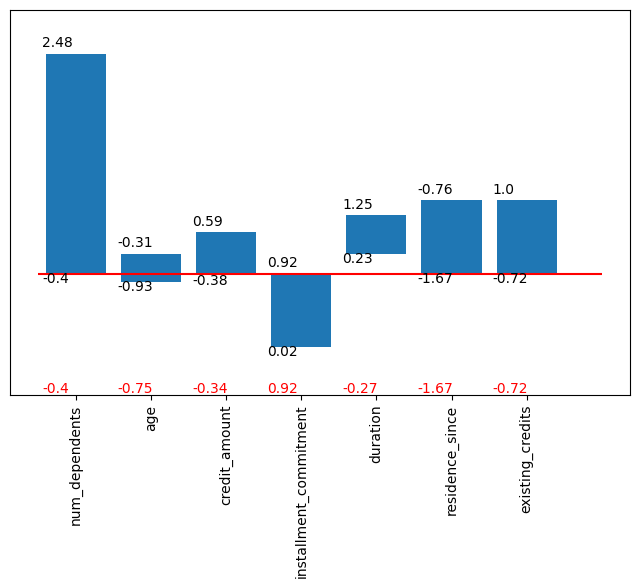

In [56]:
#plt.savefig("./../../results/discussion_tsne_boston.pdf")

<Figure size 432x288 with 0 Axes>

<AxesSubplot:xlabel='Dim 0', ylabel='Dim 1'>

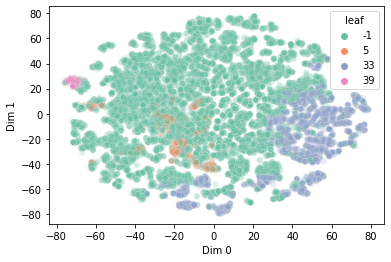

In [25]:
sns.scatterplot(x="Dim 0", y="Dim 1", data=tsne, hue="leaf", palette="Set2", alpha=0.1)#, c=[colors[i] for i in leaves_data_rearr.values])

In [45]:
gda.disc_nodes_dataset.shape

(99308, 13)

# TODO
- Categorical: quand on génère les faux jumeaux, garder en mémoire les couples des modalités: blond-brun, et le changement associé?
- TSNE: couleurs 
- relative size: devrait être nombre de noeuds de discrepancy dans la feuille sur le nombre de noeuds de discrepancy

In [10]:
x

NameError: name 'x' is not defined

(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)
(2, 63)


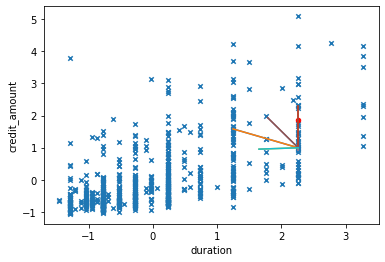

In [20]:
x = X_test.iloc[[20]]
k = 10

#dists = []
#for di in intervals:
#    dists.append( di.get_min_dist_to_point(x) )

ax = plt.subplot()
#p2g.plot_db()

X_train.plot(kind='scatter', x=0, y=1, ax=ax, marker='x')
x.plot(kind='scatter', x=0, y=1, ax=ax, c='r')

for di in np.array(intervals)[np.argsort(dists)][:k]:
    #print(di.border_features)
    #print(di.border_bounds_discrepancies)
    print(di.border_features.shape)
    plt.plot(di.border_features.iloc[:,0], di.border_features.iloc[:,1])
